## 1. Постановка задачи


В данном проекте вы решите настоящую бизнес-задачу в области маркетинга. Вам предстоит произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. 

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## 2. Знакомство с данными. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


Для начала давайте познакомимся с нашими данными:

In [2]:
data = pd.read_csv(
    "./data/customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.


### Задание 2.1
Сколько столбцов в данных кодируются числовыми типами (int/float)?

In [3]:
num_cols = data.select_dtypes(include='number').shape[1]
print(num_cols)

2


### Задание 2.2
Выберите столбцы, в которых есть хотя бы один пропуск:
* InvoiceNo
* StockCode
* Description
* CustomerID
* Country 

In [4]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Задание 2.3
Судя по описанию задачи, нам должны были предоставить данные за годовой период — проверим, так ли это.

Преобразуйте столбец InvoiceDate в формат datetime.
Укажите, за какой промежуток времени представлены данные:

* 2010-12-01 to 2011-12-09
* 2011-12-01 to 2012-12-09
* 2010-01-01 to 2011-01-09
* 2020-12-01 to 2021-12-09


In [5]:
# преобразуем в datetime
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

# проверяем диапазон
start_date = data["InvoiceDate"].min()
end_date   = data["InvoiceDate"].max()

print("Данные с", start_date, "по", end_date)

Данные с 2010-12-01 08:26:00 по 2011-12-09 12:50:00


### Задание 2.4

1) Каково максимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

2) Каково минимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

3) Сколько, согласно данным, стоит самый дешёвый товар (за исключением товаров с отрицательной стоимостью)?

In [6]:
print('Максимальное количество товаров в заказе (Quantity): ', data['Quantity'].max().round())
print('Минимальное количество товаров в заказе (Quantity): ', data['Quantity'].min().round())
print('Cамый дешёвый товар (за исключением товаров с отрицательной стоимостью) стоит: ', data.loc[data['UnitPrice'] >= 0, 'UnitPrice'].min())

Максимальное количество товаров в заказе (Quantity):  80995
Минимальное количество товаров в заказе (Quantity):  -80995
Cамый дешёвый товар (за исключением товаров с отрицательной стоимостью) стоит:  0.0


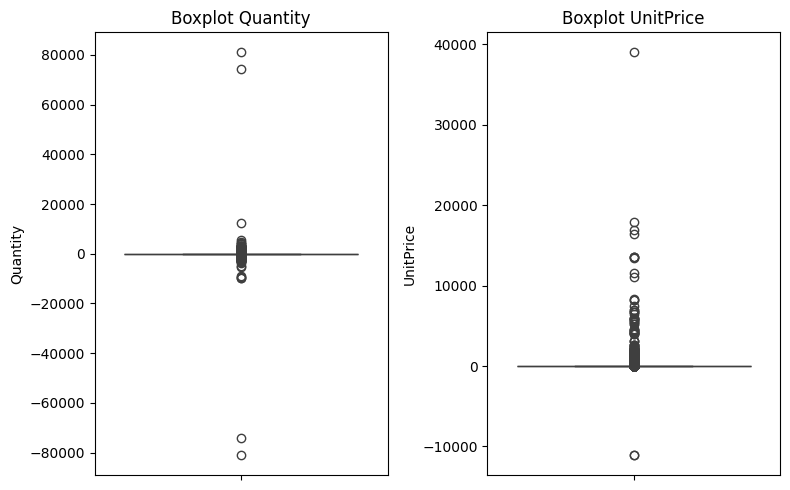

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# Boxplot для Quantity
sns.boxplot(y=data['Quantity'], ax=axes[0])
axes[0].set_title("Boxplot Quantity")
axes[0].set_ylabel("Quantity")

# Boxplot для UnitPrice
sns.boxplot(y=data['UnitPrice'], ax=axes[1])
axes[1].set_title("Boxplot UnitPrice")
axes[1].set_ylabel("UnitPrice")

plt.tight_layout()
plt.show()

### Задание 2.5
1) Сколько уникальных клиентов покупали товары за период выгрузки датасета?

2) Сколько уникальных стран содержится в столбце Country (исключая специальный код 'Unspecified', обозначающий неопределенную страну)?

3) Укажите идентификатор самого популярного товара (StockCode):
* 85123A
* 64812
* 51242
* 24151B


In [8]:
print('Количество уникальных клиентов за период выгрузки датасета: ', data['CustomerID'].nunique())
print('Количество уникальных стран: ', data.loc[data['Country'] != 'Unspecified', 'Country'].nunique())
print('Идентификатор самого популярного товара: ', data['StockCode'].value_counts().idxmax())

Количество уникальных клиентов за период выгрузки датасета:  4372
Количество уникальных стран:  37
Идентификатор самого популярного товара:  85123A


## 3. Предобработка и очистка данных

На этом этапе нам предстоит подготовить наш датасет для дальнейшего моделирования, произведя очистку данных.


### Задание 3.1
Начнем с пропусков. 

1) Сколько всего в таблице пропущенных значений?

2) Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях.

Удалите строки, содержащие пропуски в этих столбцах. Сколько строк осталось в таблице?



In [9]:
print('Количество пропущенных значений: ', data.isna().sum().sum())

df = data.copy()
df = data.dropna(subset=['CustomerID', 'Description'])

print("Количество строк после удаления:", len(df))

Количество пропущенных значений:  136534
Количество строк после удаления: 406829


### Задание 3.2
Следом за пропусками проверим наличие дубликатов.

1) Сколько в таблице полностью дублирующихся записей?

2) Удалите дубликаты из таблицы. Сколько строк осталось?



In [10]:
print("Количество дубликатов:", df.duplicated().sum())

# удаляем дубликаты
df = df.drop_duplicates()

print("Количество строк после удаления дубликатов:", len(df))

Количество дубликатов: 5225
Количество строк после удаления дубликатов: 401604


Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [11]:
negative_quantity = df[(df['Quantity']<0)]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


### Задание 3.3
Давайте проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

Сколько транзакций из таблицы negative_quantity не содержат в номере заказа признак возврата?

In [12]:
# фильтруем строки с отрицательным количеством и без "C" в InvoiceNo
negative_non_return = negative_quantity[~negative_quantity['InvoiceNo'].str.startswith('C')]

# количество таких строк
count_non_return = negative_non_return.shape[0]

print("Количество транзакций с отрицательным Quantity без возврата:", count_non_return)

Количество транзакций с отрицательным Quantity без возврата: 0


Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [13]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


### Задание 3.4
Добавьте во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

Сколько процентов заказов в таблице являются возвратами? Ответ приведите в виде целого числа.


In [14]:
# добавляем признак отмены заказа
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].str.startswith('C').astype(int)

# считаем процент возвратов
percent_canceled = int(round(nb_products_per_basket['order_canceled'].mean() * 100))

print("Процент возвратов:", percent_canceled, "%")

Процент возвратов: 16 %


Давайте поближе взглянем на отмененные заказы:


In [15]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [16]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Итак, вот пример пары «заказ-отмена». Обратите внимание на столбцы StockCode, UnitPrice, CustomerID и Quantity, сравните их для двух транзакций. 

### Задание 3.5
Выдвигаем гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

* Верна ли гипотеза?
* Да, верна



In [17]:
# 1. Отрицательные транзакции
negative_quantity = data[data['Quantity'] < 0].copy()
negative_quantity['Quantity_abs'] = -negative_quantity['Quantity']  # ожидаемое положительное значение

# 2. Положительные транзакции (кандидаты на «аналог»)
positive_quantity = data[['CustomerID', 'StockCode', 'Quantity']].copy()

# 3. Merge по CustomerID, StockCode и Quantity_abs == Quantity
merged = negative_quantity.merge(
    positive_quantity,
    left_on=['CustomerID', 'StockCode', 'Quantity_abs'],
    right_on=['CustomerID', 'StockCode', 'Quantity'],
    how='left',
    indicator=True
)

# 4. Проверяем, для каких отрицательных транзакций нет совпадений
no_match_count = (merged['_merge'] == 'left_only').sum()

print("Количество отрицательных транзакций без обратного аналога:", no_match_count)

Количество отрицательных транзакций без обратного аналога: 6906


Давайте приведем контр-пример, на котором "споткнулась" наша прошлая гипотеза. Посмотрим на клиента с идентификатором 14527:

In [18]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратите внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров вы не найдёте. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

### Задание 3.6
Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

Верна ли гипотеза?
* Да, верна
* Нет, не верна 


In [19]:
# 1️⃣ Отрицательные транзакции без скидки
negative_quantity = data[(data['Quantity'] < 0) & (data['StockCode'] != 'D')].copy()
negative_quantity['Quantity_abs'] = -negative_quantity['Quantity']  # ожидаемое положительное значение

# 2️⃣ Положительные транзакции без скидки
positive_quantity = data[(data['StockCode'] != 'D')][['CustomerID', 'StockCode', 'Quantity']].copy()

# 3️⃣ Merge для поиска аналога
merged = negative_quantity.merge(
    positive_quantity,
    left_on=['CustomerID', 'StockCode', 'Quantity_abs'],
    right_on=['CustomerID', 'StockCode', 'Quantity'],
    how='left',
    indicator=True
)

# 4️⃣ Считаем, сколько отрицательных транзакций не имеют обратного аналога
no_match_count = (merged['_merge'] == 'left_only').sum()

print("Количество отрицательных транзакций без аналога (без скидок):", no_match_count)

Количество отрицательных транзакций без аналога (без скидок): 6829


Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [20]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Мы подготовили для вас функцию get_quantity_canceled(). Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled.


In [21]:
"""
def get_quantity_canceled_platform(data):
    # Инициализируем нулями Series той же длины, что и столбцы таблицы
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех транзакций, противоположных возвратам
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет противоположной — ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет только одну противоположную транзакцию
        # Добавляем количество возвращённого товара в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько противоположных транзакций
        # Вносим количество возвращённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > (-1) * (количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

quantity_canceled_platform = get_quantity_canceled_platform(df)

quantity_canceled_platform.sum()
"""

"\ndef get_quantity_canceled_platform(data):\n    # Инициализируем нулями Series той же длины, что и столбцы таблицы\n    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    \n    negative_quantity = data[(data['Quantity'] < 0)].copy()\n    for index, col in negative_quantity.iterrows():\n        # Создаём DataFrame из всех транзакций, противоположных возвратам\n        df_test = data[(data['CustomerID'] == col['CustomerID']) &\n                       (data['StockCode']  == col['StockCode']) & \n                       (data['InvoiceDate'] < col['InvoiceDate']) & \n                       (data['Quantity'] > 0)].copy()\n        # Транзация-возврат не имеет противоположной — ничего не делаем\n        if (df_test.shape[0] == 0): \n            continue\n        # Транзакция-возврат имеет только одну противоположную транзакцию\n        # Добавляем количество возвращённого товара в столбец QuantityCanceled \n        elif (df_test.shape[0] == 1): \n            index_ord

In [22]:
def get_quantity_canceled_fast(data):
    # Сохраняем исходные индексы и не трогаем входной df
    df = data.reset_index().rename(columns={'index': 'orig_index'})

    # Разделяем возвраты и покупки
    returns = df[df['Quantity'] < 0].copy()
    returns['Quantity_abs'] = -returns['Quantity']

    purchases = df[df['Quantity'] > 0].copy()

    # Матчинг по ключам (CustomerID, StockCode)
    m = returns.merge(
        purchases,
        on=['CustomerID', 'StockCode'],
        suffixes=('_ret', '_pur'),
        how='left'
    )

    # Оставляем только покупки ДО даты возврата
    m = m[m['InvoiceDate_pur'] < m['InvoiceDate_ret']].copy()

    # Сколько кандидатов у каждого возврата
    cand_count = m.groupby('orig_index_ret').size().rename('cand_count')
    m = m.merge(cand_count, left_on='orig_index_ret', right_index=True, how='left')

    # --- Случай A: ровно один кандидат -> берем его БЕЗ проверки количества
    one = m[m['cand_count'] == 1][['orig_index_ret', 'orig_index_pur', 'Quantity_abs']].copy()

    # --- Случай B: более одного кандидата -> оставляем только с достаточным количеством,
    # выбираем самый "поздний" по индексу покупки (как у тебя: sort_index(desc))
    many = m[m['cand_count'] > 1].copy()
    many = many[many['Quantity_pur'] >= many['Quantity_abs']]
    many = many.sort_values(['orig_index_ret', 'orig_index_pur'], ascending=[True, False])
    many = many.drop_duplicates(subset='orig_index_ret', keep='first')
    many = many[['orig_index_ret', 'orig_index_pur', 'Quantity_abs']]

    # Объединяем
    chosen = pd.concat([one, many], ignore_index=True)

    # ВАЖНО: присваиваем в порядке возвратов (как в твоём цикле),
    # чтобы возможные перезаписи шли одинаково
    chosen = chosen.sort_values('orig_index_ret')

    # Готовим результат
    out = pd.Series(0, index=df['orig_index'])
    out.loc[chosen['orig_index_pur'].values] = chosen['Quantity_abs'].values

    # Вернем в индекс исходного data
    return out.reindex(data.index)


df['QuantityCanceled'] = get_quantity_canceled_fast(df)

### Задание 3.7
Подсчитайте суммарное количество отмененных товаров в столбце QuantityCanceled. 


In [23]:
df['QuantityCanceled'].sum()

245266

## Задание 3.8
Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. 
Удалите из таблицы транзакции, в поле которых указано отрицательное количество товара.  
Сколько записей осталось?

In [24]:
# удаляем возвраты
data_clean = df[df["Quantity"] > 0].copy()

# смотрим количество строк
len(data_clean)

392732

Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Давайте проверим, бывают ли другие специальные коды.


### Задание 3.9
С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры). 

Подсказка: Поиск подстрок в столбце можно организовать с помощью str.contains(). В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'. Параметр regex установите в значение True.

1) Сколько уникальных специальных видов транзакций вам удалось найти?

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы. 

2) Сколько записей осталось?



In [25]:
# ищем StockCode, начинающиеся с латинских букв
special_codes = data_clean[data_clean["StockCode"].str.contains('^[a-zA-Z]+', regex=True)]

# сколько уникальных специальных кодов
n_unique_special = special_codes["StockCode"].nunique()
print("Уникальных специальных кодов:", n_unique_special)
print("Сами коды:", special_codes["StockCode"].unique())

# оставляем только коды, не начинающиеся с букв
data_no_special = data_clean[~data_clean["StockCode"].str.contains('^[a-zA-Z]+', regex=True)]

# сколько строк осталось
print("Осталось записей:", len(data_no_special))

Уникальных специальных кодов: 6
Сами коды: ['POST' 'C2' 'M' 'BANK CHARGES' 'PADS' 'DOT']
Осталось записей: 391183


### Задание 3.10
Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. 

1) В скольких транзакциях цена за единицу товара равна 0?

2) Таких транзакций оказалось менее 1 %, поэтому от них можно просто избавиться. Удалите такие транзакции из таблицы. Сколько записей осталось?



In [26]:
n_price_zero = (data_no_special['UnitPrice'] == 0).sum()
print("Транзакций с ценой 0:", n_price_zero)

# удаляем строки, где цена = 0
data_clean_final = data_no_special[data_no_special['UnitPrice'] != 0]

print("Осталось записей:", len(data_clean_final))

Транзакций с ценой 0: 33
Осталось записей: 391150


Поздравляем, этап очистки данных завершён. Рекомендуем сохранить полученный результат в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.

## 4. Разведывательный анализ данных

Теперь давайте займёмся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


### Задание 4.1
Для начала выясним, в каких странах живут клиенты.

Постройте график, отражающий количество клиентов в каждой из стран. Обратите внимание, что нам нужны именно уникальные клиенты.

В какой стране живёт наибольшее количество клиентов?

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


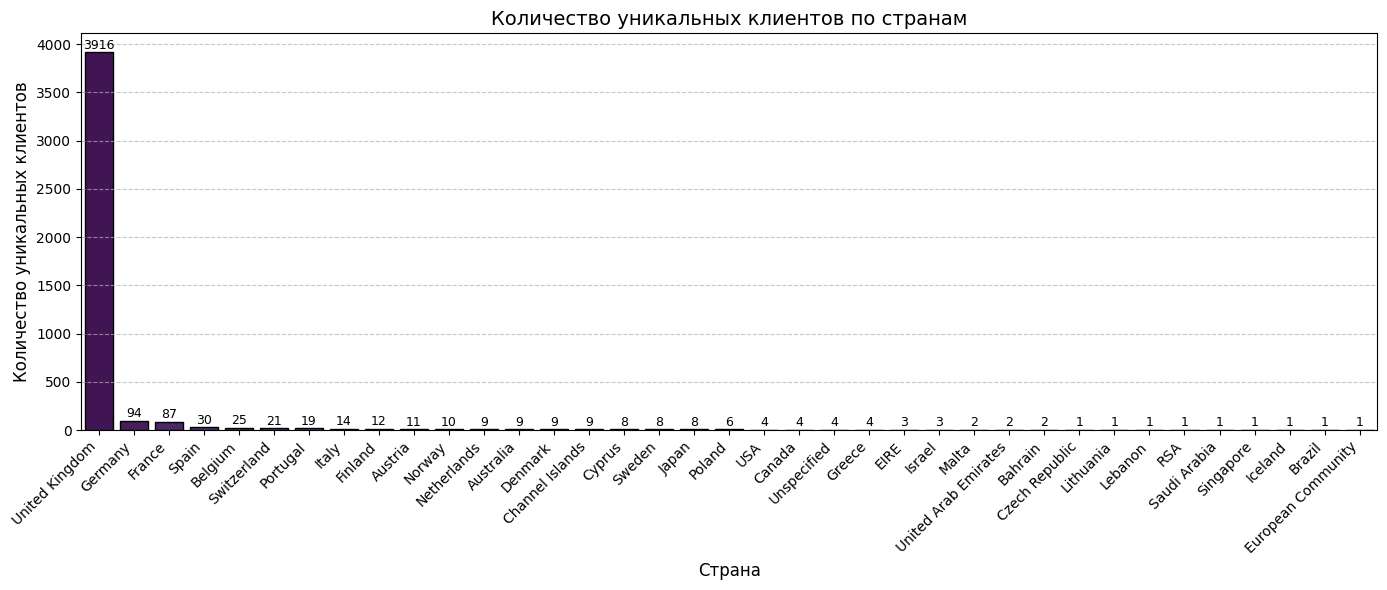

Наибольшее количество клиентов живёт в стране: United Kingdom (3916)


In [27]:
# Считаем количество уникальных клиентов по странам
clients_by_country = data_clean_final.groupby("Country")["CustomerID"].nunique().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
ax = sns.barplot(x=clients_by_country.index, y=clients_by_country.values, palette="viridis")

# Добавляем подписи с количеством клиентов над каждым столбцом
for i, v in enumerate(clients_by_country.values):
    ax.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=9)

# Сетка для наглядности
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Подписи
plt.title("Количество уникальных клиентов по странам", fontsize=14)
plt.xlabel("Страна", fontsize=12)
plt.ylabel("Количество уникальных клиентов", fontsize=12)
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

# Страна с максимальным числом клиентов
top_country = clients_by_country.idxmax()
top_count = clients_by_country.max()
print(f"Наибольшее количество клиентов живёт в стране: {top_country} ({top_count})")

### Задание 4.2
Мы посмотрели на распределение клиентов в разрезе стран. А что насчёт заказов?

Постройте визуализацию и выделите топ-3 стран по количеству поступающих заказов.

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


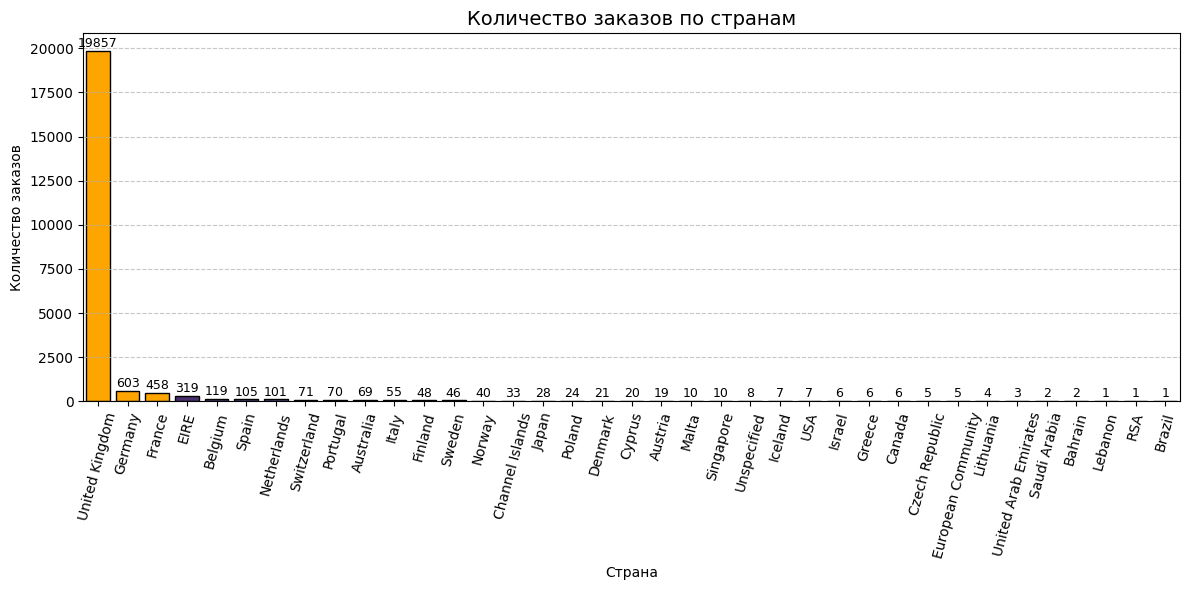

Топ-3 стран по количеству заказов:
Country
United Kingdom    19857
Germany             603
France              458
Name: InvoiceNo, dtype: int64


In [28]:
# количество заказов по странам
orders_by_country = df.groupby("Country")["InvoiceNo"].nunique().sort_values(ascending=False)

# выделим топ-3
top3 = orders_by_country.head(3)

plt.figure(figsize=(12,6))
sns.barplot(x=orders_by_country.index, y=orders_by_country.values, palette="viridis")

# подписи над столбцами
for i, val in enumerate(orders_by_country.values):
    plt.text(i, val+50, str(val), ha='center', va='bottom', fontsize=9)

# подсветим топ-3 другим цветом
for i, country in enumerate(orders_by_country.index):
    if country in top3.index:
        plt.gca().patches[i].set_facecolor("orange")

plt.xticks(rotation=75)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title("Количество заказов по странам", fontsize=14)
plt.ylabel("Количество заказов")
plt.xlabel("Страна")
plt.tight_layout()
plt.show()

print("Топ-3 стран по количеству заказов:")
print(top3)

### Задание 4.3
Давайте добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Чему равна средняя общая стоимость заказов? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [29]:
df_eda = data_clean_final.copy()

# создаём столбец TotalPrice
df_eda['TotalPrice'] = df_eda['UnitPrice'] * (df_eda['Quantity'] - df_eda['QuantityCanceled'])

print("Общая средняя стоимость заказа:", df_eda['TotalPrice'].mean().round(), "фунтов")

Общая средняя стоимость заказа: 21.0 фунтов


### Задание 4.4

Постройте визуализацию и выделите топ-3 стран, клиенты из которых приносят компании больше всего выручки:
* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


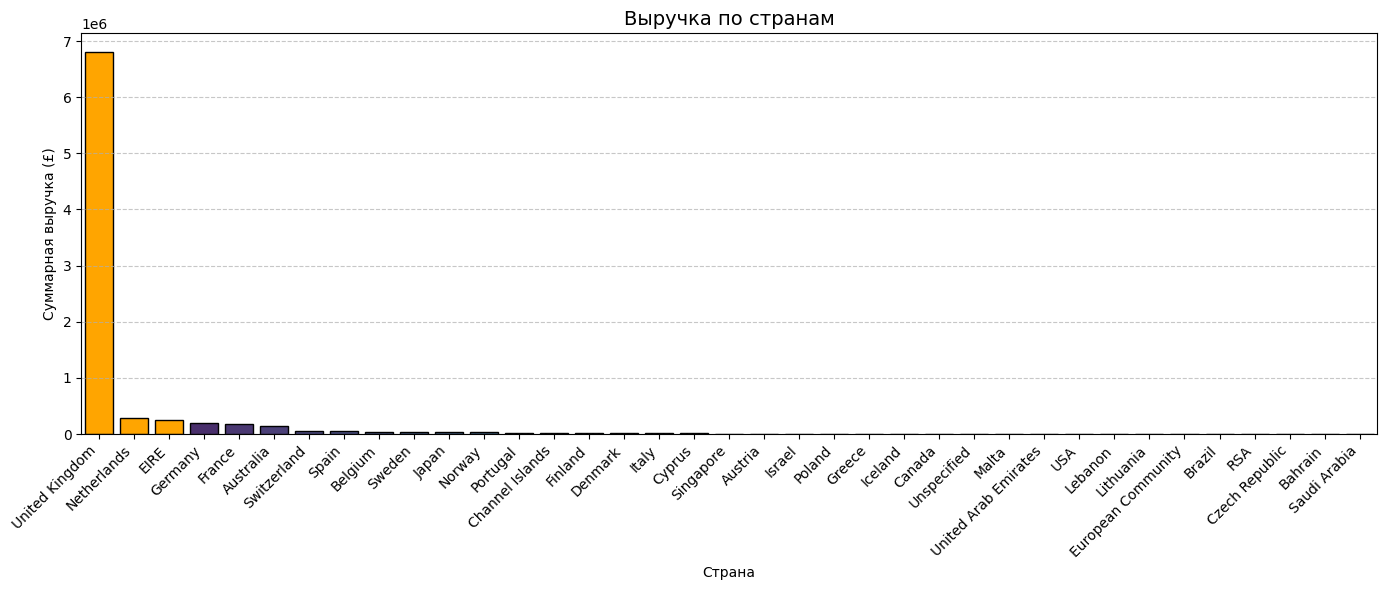

Топ-3 стран по выручке:
Country
United Kingdom    6797691.44
Netherlands        283443.54
EIRE               247074.57
Name: TotalPrice, dtype: float64


In [30]:
# суммарная выручка по странам
revenue_by_country = df_eda.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

# топ-3 стран по выручке
top3_revenue = revenue_by_country.head(3)

plt.figure(figsize=(14,6))
ax = sns.barplot(x=revenue_by_country.index, y=revenue_by_country.values, palette="viridis")

# подсветка топ-3 оранжевым
for i, country in enumerate(revenue_by_country.index):
    if country in top3_revenue.index:
        ax.patches[i].set_facecolor("orange")

plt.xticks(rotation=45, ha='right')
plt.title("Выручка по странам", fontsize=14)
plt.ylabel("Суммарная выручка (£)")
plt.xlabel("Страна")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Топ-3 стран по выручке:")
print(top3_revenue)

Теперь займёмся временными характеристиками.


### Задание 4.5
Добавьте в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

Постройте визуализацию, отражающую распределение суммарной выручки от заказов по месяцам. Укажите номер самого прибыльного для компании месяца. Предположите, почему так происходит.

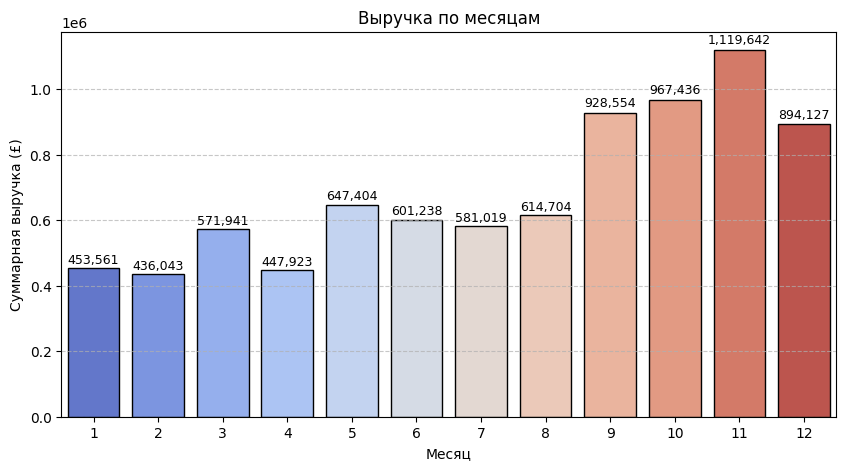

Самый прибыльный месяц: 11


In [31]:
# добавляем признаки времени
df_eda['Month'] = df_eda['InvoiceDate'].dt.month
df_eda['Weekday'] = df_eda['InvoiceDate'].dt.dayofweek  # 0=Monday
df_eda['Hour'] = df_eda['InvoiceDate'].dt.hour

# суммарная выручка по месяцам
revenue_by_month = df_eda.groupby('Month')['TotalPrice'].sum()

# визуализация
plt.figure(figsize=(10,5))
sns.barplot(x=revenue_by_month.index, y=revenue_by_month.values, palette="coolwarm")
plt.xlabel("Месяц")
plt.ylabel("Суммарная выручка (£)")
plt.title("Выручка по месяцам")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# подписи с суммой выручки над столбцами
for i, val in enumerate(revenue_by_month.values):
    plt.text(i, val + val*0.01, f"{val:,.0f}", ha='center', va='bottom', fontsize=9)

plt.show()

# самый прибыльный месяц
most_profitable_month = revenue_by_month.idxmax()
print("Самый прибыльный месяц:", most_profitable_month)

 Такой результат объясняется довольно просто: ноябрь предшествует декабрю, а в декабре отмечаются католическое Рождество и Новый год. Так как мы анализируем данные магазина подарков, то совсем не удивительно, что мы видим максимальный рост продаж в преддверии этих праздников.

### Задание 4.6
Постройте визуализацию количества заказов для каждого дня недели. Укажите день недели, в который, согласно данным, не совершено ни одного заказа:
* Понедельник
* Вторник
* Среда
* Четверг
* Пятница
* Суббота 
* Воскресенье


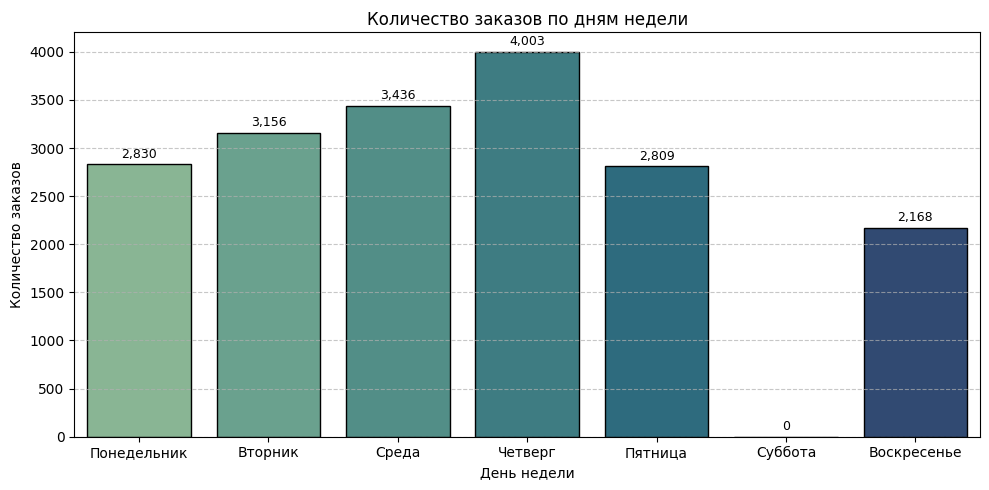

Дни без заказов: Суббота


In [32]:
# словарь для замены номеров на названия
weekday_names = {
    0: "Понедельник",
    1: "Вторник",
    2: "Среда",
    3: "Четверг",
    4: "Пятница",
    5: "Суббота",
    6: "Воскресенье"
}

# создаём полный индекс дней (0..6) и считаем уникальные заказы по дням
full_idx = pd.Index(range(7), name="Weekday")
orders_by_weekday = df_eda.groupby("Weekday")["InvoiceNo"].nunique().reindex(full_idx, fill_value=0)

# переименовываем индекс в читаемые названия и сохраняем порядок Пн..Вс
orders_by_weekday_named = orders_by_weekday.rename(index=weekday_names)

# визуализация
plt.figure(figsize=(10,5))
ax = sns.barplot(x=orders_by_weekday_named.index, y=orders_by_weekday_named.values, palette="crest")
plt.xlabel("День недели")
plt.ylabel("Количество заказов")
plt.title("Количество заказов по дням недели")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# подписи над столбцами (смещаем немного вверх, чтобы метки были видны даже для 0)
max_val = orders_by_weekday_named.max()
offset = max(max_val * 0.01, 1)  # хотя бы 1, чтобы метки для нулей не накладывались
for i, val in enumerate(orders_by_weekday_named.values):
    ax.text(i, val + offset, f"{int(val):,}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# поиск дней без заказов
days_no_orders = [name for name, cnt in orders_by_weekday_named.items() if cnt == 0]
if days_no_orders:
    print("Дни без заказов:", ", ".join(days_no_orders))
else:
    print("Во все дни недели были заказы.")

### Задание 4.7
Выделите дату из признака времени совершения транзакции.
Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.

Постройте визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

Выберите верные утверждения:
* Больше всего заказов совершается в дневное время в интервале от 18 до 20 часов
* Больше всего заказов совершается в вечернее время в интервале от 10 до 15 часов
* Начиная с 21 часа вечера и до 6 утра (не включительно) заказы не поступают 
* Заказы поступают во все периоды дня


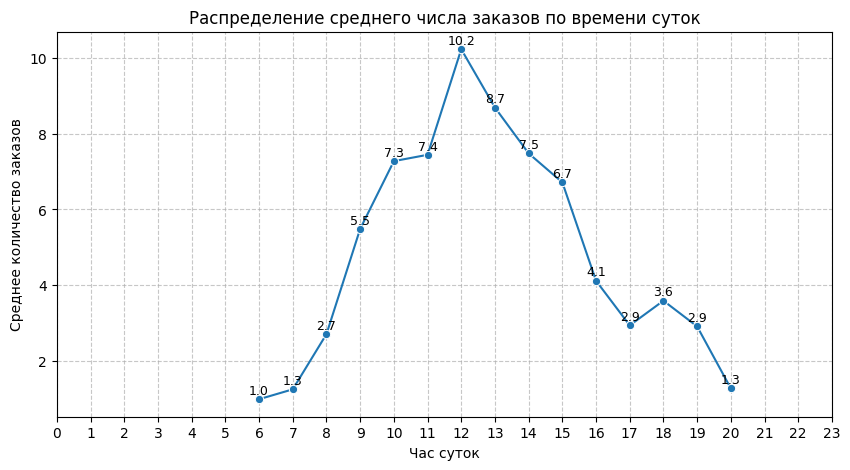

In [33]:
df_eda["Date"] = df_eda["InvoiceDate"].dt.date

# считаем количество уникальных заказов по каждому дню-часу
orders_day_hour = (
    df_eda.groupby(["Date", "Hour"])["InvoiceNo"]
    .nunique()
    .reset_index(name="Orders")
)

# считаем среднее количество заказов для каждого часа
avg_orders_by_hour = (
    orders_day_hour.groupby("Hour")["Orders"]
    .mean()
    .reset_index()
)

# визуализация
plt.figure(figsize=(10,5))
sns.lineplot(x="Hour", y="Orders", data=avg_orders_by_hour, marker="o")
plt.xlabel("Час суток")
plt.ylabel("Среднее количество заказов")
plt.title("Распределение среднего числа заказов по времени суток")

# подписи над точками
for i, row in avg_orders_by_hour.iterrows():
    plt.text(row["Hour"], row["Orders"] + 0.05,  # чуть выше точки
             f"{row['Orders']:.1f}", 
             ha="center", va="bottom", fontsize=9)
    
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(range(0,24))  # часы от 0 до 23
plt.show()

## 5. RFM-сегментация клиентов: часть 1

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

### Задание 5.1

Итак, приступим к созданию нашей RFM-таблицы. 

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

Когда вы рассчитаете все характеристики, не забудьте дать столбцам результирующей таблицы соответствующие названия.

In [34]:
# точка отсчёта
t0 = pd.to_datetime("2011-12-10 00:00:00")

# RFM-таблица
rfm = df_eda.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (t0 - x.max()).days,   # Recency
    "InvoiceNo": "nunique",                         # Frequency
    "TotalPrice": "sum"                             # Monetary
}).reset_index()

# переименуем колонки
rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,0.00
1,12347,2,7,4310.00
2,12348,75,4,1437.24
3,12349,18,1,1457.55
4,12350,310,1,294.40


1) Сколько клиентов совершили покупку более 200 дней назад?

2) Сколько заказов в среднем делает клиент (за представленный годовой период)? Ответ округлите до целого числа.

3) Чему равна общая сумма денег, которую потратил клиент с идентификатором 12360? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [35]:
clients_200_plus = (rfm["Recency"] > 200).sum()
print("Клиентов с Recency > 200 дней:", clients_200_plus)

avg_orders = round(rfm["Frequency"].mean())
print("Среднее количество заказов:", avg_orders)

monetary_12360 = round(rfm.loc[rfm["CustomerID"] == '12360', "Monetary"].values[0])
print("Общая сумма клиента 12360 (в фунтах):", monetary_12360)

Клиентов с Recency > 200 дней: 743
Среднее количество заказов: 4
Общая сумма клиента 12360 (в фунтах): 2302


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

In [36]:
columns = ["Recency", "Frequency", "Monetary"]
boxes = [px.box(rfm, x=col) for col in columns]

fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
#fig.write_html('plotly/boxplot_1.html')
fig.show()

[Посмотреть интерактивный график](https://dafe1988.github.io/SF-DSPR-174/PROJECT-6/plotly/boxplot_1.html)

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


### Задание 5.2
Удалите из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$frequency >frequency_{0.95}$

$monetary >monetary_{0.95}$ 

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков. 

Данные о скольких клиентах у вас остались в RFM-таблице?


In [37]:
# вычисляем 95-й перцентиль
freq_95 = rfm["Frequency"].quantile(0.95)
mon_95 = rfm["Monetary"].quantile(0.95)

# фильтруем таблицу
rfm_filtered = rfm[(rfm["Frequency"] <= freq_95) & (rfm["Monetary"] <= mon_95)]

# количество оставшихся клиентов
remaining_clients = rfm_filtered.shape[0]
print("Количество клиентов после удаления верхних 5%:", remaining_clients)

Количество клиентов после удаления верхних 5%: 4044


После удаления выбросов у вас должны получиться следующие коробчатые диаграммы:


In [38]:
columns = ["Recency", "Frequency", "Monetary"]
boxes = [px.box(rfm_filtered, x=col) for col in columns]

fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
#fig.write_html('plotly/boxplot_2.html')
fig.show()

[Посмотреть интерактивный график](https://dafe1988.github.io/SF-DSPR-174/PROJECT-6/plotly/boxplot_2.html)

Мы наконец добрались до этапа кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:


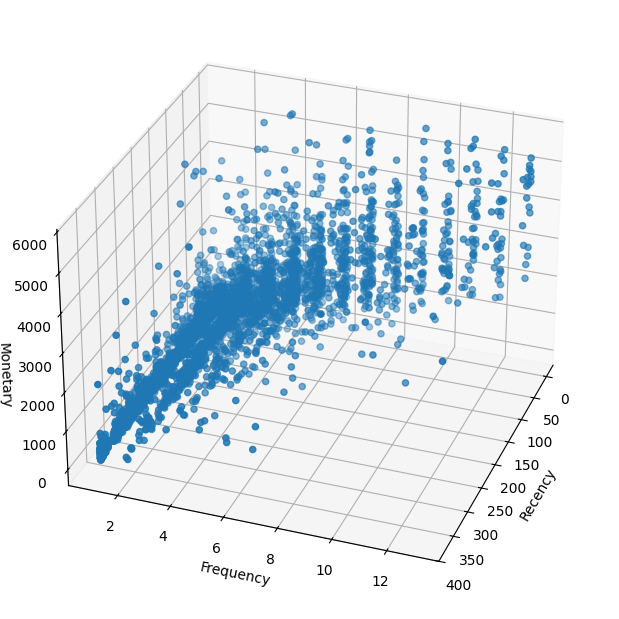

In [39]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_filtered['Recency'].to_list(), 
    rfm_filtered['Frequency'].to_list(),
    rfm_filtered['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


Что здесь можно увидеть? На самом деле, ничего конкретного. Да, видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Давайте призовём на помощь методы снижения размерности.


### Задание 5.3
Начнём с метода главных компонент (PCA). Нам известно, что для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Давайте для удобства обернём эти шаги по предобработке данных в pipeline.

Создайте pipeline, в котором будут следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* метод главных компонент с двумя компонентами.

Обучите ваш pipeline на RFM-таблице, очищенной от выбросов, и примените к ней трансформацию.

Какую долю дисперсии исходных данных объясняет первая главная компонента? Ответ округлите до двух знаков после точки-разделителя.



In [40]:
# признаки для PCA
X = rfm_filtered[["Recency", "Frequency", "Monetary"]]

# pipeline: стандартизация + PCA
pipe = pipeline.Pipeline([
    ("scaler", preprocessing.StandardScaler()),
    ("pca", decomposition.PCA(n_components=2))
])

# обучение и трансформация
X_pca = pipe.fit_transform(X)

# доля объяснённой дисперсии
explained_var = pipe.named_steps["pca"].explained_variance_ratio_
print("Доля дисперсии первой компоненты:", round(explained_var[0], 2))

Доля дисперсии первой компоненты: 0.68


Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

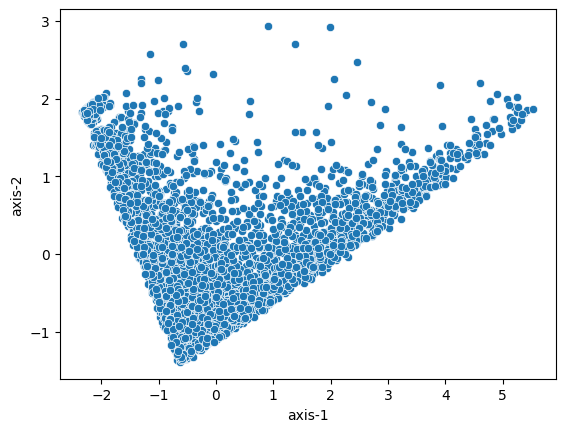

In [41]:
rfm_table_processed = pd.DataFrame(X_pca, columns=['axis-1', 'axis-2'])
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Попробуем разделить это пространство главных компонент на сегменты. 

### Задание 5.4
Попробуем воспользоваться методом k-means. 

Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


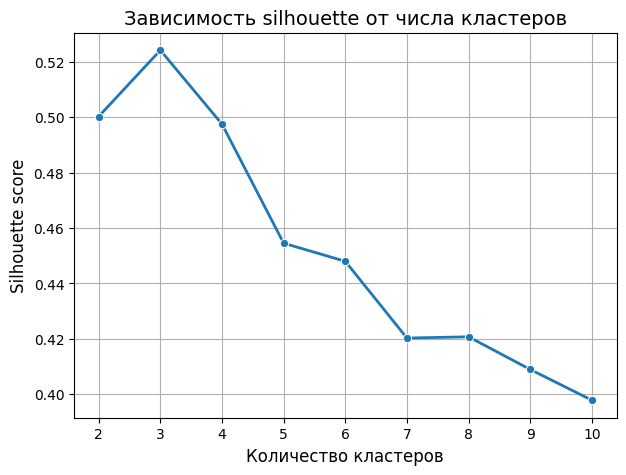

Лучший silhouette = 0.52 при k = 3


In [42]:
def get_silhouette(cluster_num, X):
    k_means =  cluster.KMeans(n_clusters=cluster_num, random_state=42)
    k_means.fit(X)
    silhouette = metrics.silhouette_score(X, k_means.labels_, metric='euclidean')
    return silhouette

silhouettes = []
for i in range(2, 11):
    silhouettes.append(get_silhouette(i, X_pca))
    
# данные для графика
clusters = list(range(2, 11))

plt.figure(figsize=(7, 5))
sns.lineplot(x=clusters, y=silhouettes, marker="o", linewidth=2)

plt.xlabel("Количество кластеров", fontsize=12)
plt.ylabel("Silhouette score", fontsize=12)
plt.title("Зависимость silhouette от числа кластеров", fontsize=14)
plt.grid(True)   # сетка
plt.show()

# ищем лучший результат
best_idx = max(range(len(silhouettes)), key=lambda i: silhouettes[i])
best_cluster = clusters[best_idx]
best_score = silhouettes[best_idx]

print(f"Лучший silhouette = {best_score:.2f} при k = {best_cluster}")

### Задание 5.5
Теперь возьмём EM-алгоритм.

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


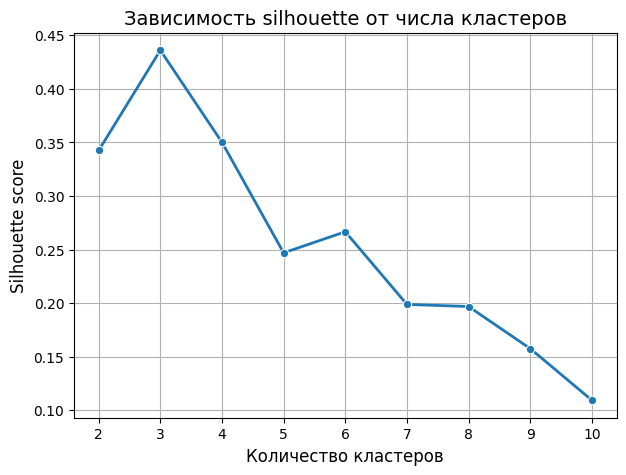

Лучший silhouette = 0.44 при k = 3


In [43]:
def get_silhouette_em(cluster_num, X):
    em =  mixture.GaussianMixture(n_components=cluster_num, random_state=42)
    em.fit(X)
    silhouette = metrics.silhouette_score(X, em.predict(X), metric='euclidean')
    return silhouette

silhouettes = []
for i in range(2, 11):
    silhouettes.append(get_silhouette_em(i, X_pca))
    
# данные для графика
clusters = list(range(2, 11))

plt.figure(figsize=(7, 5))
sns.lineplot(x=clusters, y=silhouettes, marker="o", linewidth=2)

plt.xlabel("Количество кластеров", fontsize=12)
plt.ylabel("Silhouette score", fontsize=12)
plt.title("Зависимость silhouette от числа кластеров", fontsize=14)
plt.grid(True)   # сетка
plt.show()

# ищем лучший результат
best_idx = max(range(len(silhouettes)), key=lambda i: silhouettes[i])
best_cluster = clusters[best_idx]
best_score = silhouettes[best_idx]

print(f"Лучший silhouette = {best_score:.2f} при k = {best_cluster}")

### Задание 5.6
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



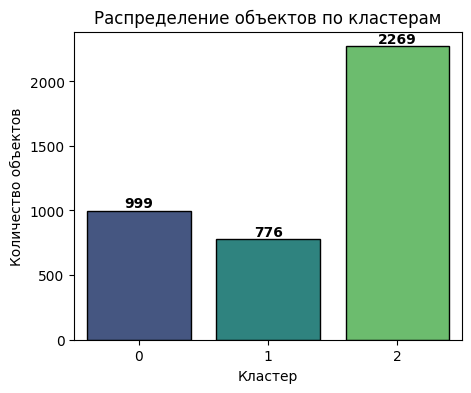

Самый малочисленный кластер: 1 (776 объектов)
Самый многочисленный кластер: 2 (2269 объектов)


In [44]:
k_means =  cluster.KMeans(n_clusters=3, random_state=42)
k_means.fit(X_pca)

# Считаем количество объектов в каждом кластере
cluster_counts = pd.Series(k_means.labels_).value_counts().sort_index()

# --- Визуализация ---
plt.figure(figsize=(5,4))
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")

# Подписи на столбцах
for i, v in enumerate(cluster_counts.values):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.xlabel("Кластер")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по кластерам")
plt.show()

# --- Самый малочисленный и самый многочисленный кластеры ---
min_cluster = cluster_counts.idxmin()
min_count = cluster_counts.min()

max_cluster = cluster_counts.idxmax()
max_count = cluster_counts.max()

print(f"Самый малочисленный кластер: {min_cluster} ({min_count} объектов)")
print(f"Самый многочисленный кластер: {max_cluster} ({max_count} объектов)")

Визуализируем результаты кластеризации:

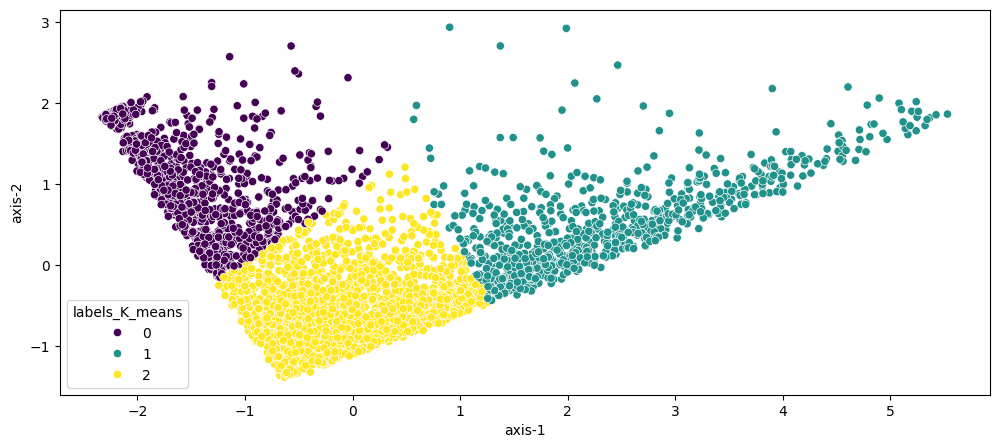

In [45]:
rfm_table_processed['labels_K_means'] = k_means.labels_
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue='labels_K_means',
    palette="viridis"
);

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

### Задание 5.7

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чему равно максимальное среднее значение признака Frequency в полученной таблице? Ответ округлите до целого числа.

In [46]:
rfm_filtered['labels_K_means'] = k_means.labels_
grouped = rfm_filtered.iloc[:, 1:].groupby('labels_K_means').mean()
print('Максимальное среднее значение признака Frequency: ', grouped['Frequency'].max().round())

Максимальное среднее значение признака Frequency:  7.0


### Полярная диаграмма
Сейчас мы познакомимся с одним из способов визуализации профиля кластеров — Radar Chart (полярная, или лепестковая, диаграмма). Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».
Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 
Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На данной диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие к данному кластеру, в большей степени увлекаются музыкой (Music), а в меньшей степени — программированием (Programm).

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализовали собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в реализацию функции plot_cluster_profile().

In [47]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    fig.write_html(f'plotly/cluster_profile_{n_clusters}.html')
    # Отображаем фигуру
    fig.show()

Теперь у нас есть удобный инструмент для анализа профиля кластеров. Давайте воспользуемся им.


### Задание 5.8

Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

Описание кластера:
* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.


In [48]:
plot_cluster_profile(grouped, 3)

[Посмотреть интерактивный график](https://dafe1988.github.io/SF-DSPR-174/PROJECT-6/plotly/cluster_profile_3.html)

- Кластер 1 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
- Кластер 2 соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
- Кластер 0 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.

In [49]:
scaler = preprocessing.MinMaxScaler()
grouped_data = pd.DataFrame(scaler.fit_transform(grouped), columns=grouped.columns)
grouped_data

,Recency,Frequency,Monetary
0,1.000000,0.00000,0.000000
1,0.000000,1.00000,1.000000
2,0.087023,0.16343,0.120535


### 4. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Давайте попробуем и посмотрим, что получится.

### Задание 6.1
Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Давайте для удобства обернём шаги по предобработке данных в pipeline.

Создайте pipeline, который будет содержать следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.

Обучите ваш pipeline на RFM-таблице (очищенной от выбросов), полученной ранее, и примените к ней трансформацию.

Чему равно значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE? Ответ округлите до двух знаков после точки-разделителя.

**Примечание:**
Напомним, что дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями. 

Оптимальное значение данной характеристики, найденное в процессе обучения алгоритма t-SNE, хранится в атрибуте kl_divergence_ объекта класса TSNE из библиотеки sklearn. Конечно же, предварительно модель необходимо обучить, чтобы получить это значение.



In [50]:
# признаки для t-SNE
X = rfm_filtered[["Recency", "Frequency", "Monetary"]]

# pipeline: стандартизация + TSNE
pipe_tsne = pipeline.Pipeline([
    ("scaler", preprocessing.StandardScaler()),
    ("t-SNE", manifold.TSNE(n_components=2, perplexity=50, random_state=100))
])

# обучение и трансформация
X_tsne = pipe_tsne.fit_transform(X)

# дивергенция Кульбака-Лейблера
kl_divergence = pipe_tsne.named_steps["t-SNE"].kl_divergence_
print("Значение дивергенции Кульбака-Лейблера: ", round(kl_divergence, 2))

Значение дивергенции Кульбака-Лейблера:  0.54


Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


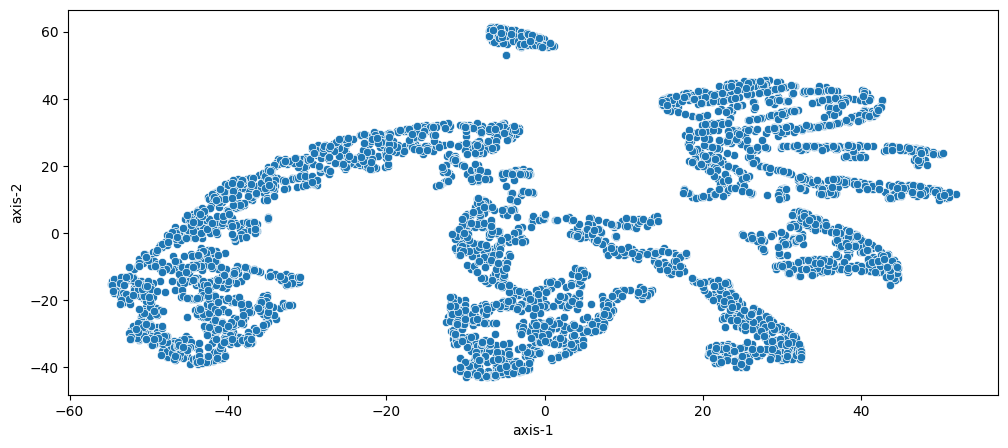

In [51]:
rfm_table_tsne = pd.DataFrame(X_tsne, columns=['axis-1', 'axis-2'])

fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_tsne, x='axis-1', y='axis-2');

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


### Задание 6.2
Попробуем воспользоваться методом k-means. 
Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



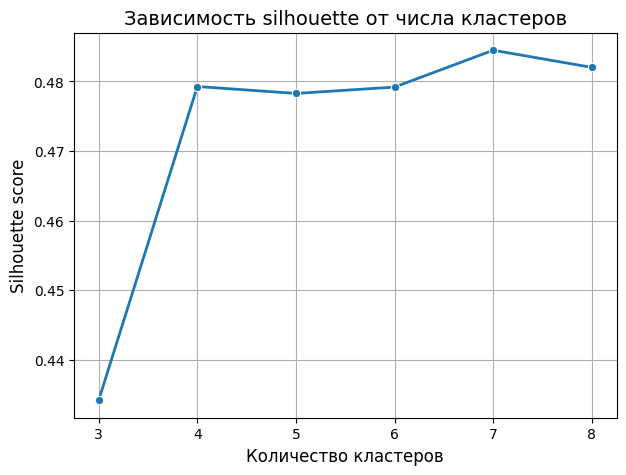

Лучший silhouette = 0.484 при k = 7


In [52]:
def get_silhouette(cluster_num, X):
    k_means =  cluster.KMeans(n_clusters=cluster_num, random_state=42)
    k_means.fit(X)
    silhouette = metrics.silhouette_score(X, k_means.labels_, metric='euclidean')
    return silhouette

silhouettes = []
for i in range(3, 9):
    silhouettes.append(get_silhouette(i, X_tsne))
    
# данные для графика
clusters = list(range(3, 9))

plt.figure(figsize=(7, 5))
sns.lineplot(x=clusters, y=silhouettes, marker="o", linewidth=2)

plt.xlabel("Количество кластеров", fontsize=12)
plt.ylabel("Silhouette score", fontsize=12)
plt.title("Зависимость silhouette от числа кластеров", fontsize=14)
plt.grid(True)   # сетка
plt.show()

# ищем лучший результат
best_idx = max(range(len(silhouettes)), key=lambda i: silhouettes[i])
best_cluster = clusters[best_idx]
best_score = silhouettes[best_idx]

print(f"Лучший silhouette = {best_score:.3f} при k = {best_cluster}")

### Задание 6.3
Попробуем воспользоваться EM-алгоритом. 

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture)  с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.

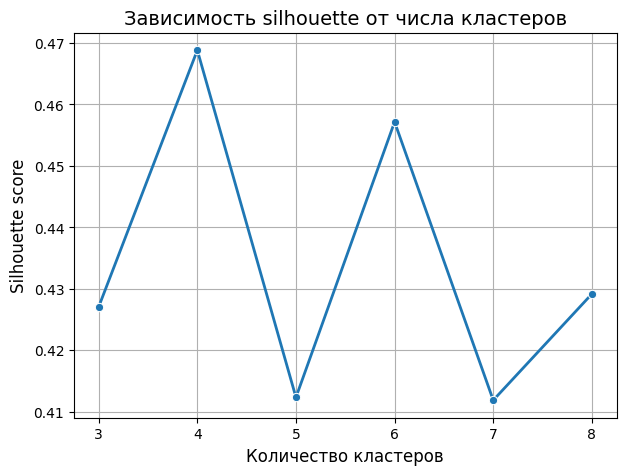

Лучший silhouette = 0.469 при k = 4


In [53]:
silhouettes = []
for i in range(3, 9):
    silhouettes.append(get_silhouette_em(i, X_tsne))
    
# данные для графика
clusters = list(range(3, 9))

plt.figure(figsize=(7, 5))
sns.lineplot(x=clusters, y=silhouettes, marker="o", linewidth=2)

plt.xlabel("Количество кластеров", fontsize=12)
plt.ylabel("Silhouette score", fontsize=12)
plt.title("Зависимость silhouette от числа кластеров", fontsize=14)
plt.grid(True)   # сетка
plt.show()

# ищем лучший результат
best_idx = max(range(len(silhouettes)), key=lambda i: silhouettes[i])
best_cluster = clusters[best_idx]
best_score = silhouettes[best_idx]

print(f"Лучший silhouette = {best_score:.3f} при k = {best_cluster}")

### Задание 6.4
Наконец, попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберите оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно. 

Все параметры, за исключением числа кластеров, оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



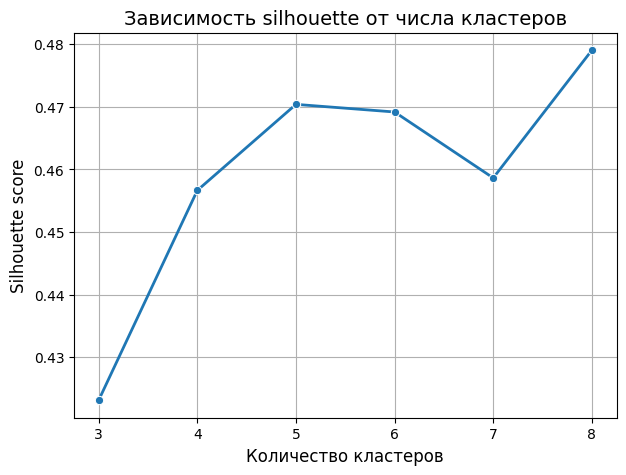

Лучший silhouette = 0.479 при k = 8


In [54]:
def get_silhouette_agg(cluster_num, X):
    agg =  cluster.AgglomerativeClustering(n_clusters=cluster_num)
    agg.fit(X)
    silhouette = metrics.silhouette_score(X, agg.labels_, metric='euclidean')
    return silhouette

silhouettes = []
for i in range(3, 9):
    silhouettes.append(get_silhouette_agg(i, X_tsne))
    
# данные для графика
clusters = list(range(3, 9))

plt.figure(figsize=(7, 5))
sns.lineplot(x=clusters, y=silhouettes, marker="o", linewidth=2)

plt.xlabel("Количество кластеров", fontsize=12)
plt.ylabel("Silhouette score", fontsize=12)
plt.title("Зависимость silhouette от числа кластеров", fontsize=14)
plt.grid(True)   # сетка
plt.show()

# ищем лучший результат
best_idx = max(range(len(silhouettes)), key=lambda i: silhouettes[i])
best_cluster = clusters[best_idx]
best_score = silhouettes[best_idx]

print(f"Лучший silhouette = {best_score:.3f} при k = {best_cluster}")

### Задание 6.5
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture
* AgglomerativeClustering


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



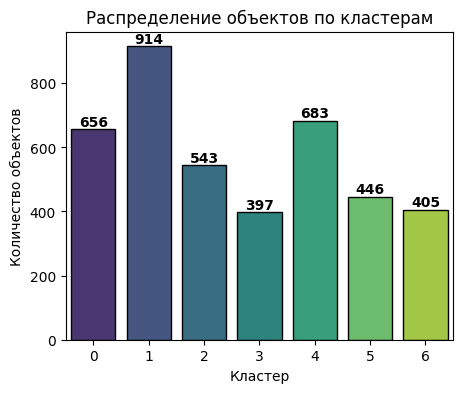

Самый малочисленный кластер: 3 (397 объектов)
Самый многочисленный кластер: 1 (914 объектов)


In [55]:
k_means =  cluster.KMeans(n_clusters=7, random_state=42)
k_means.fit(X_tsne)

# Считаем количество объектов в каждом кластере
cluster_counts = pd.Series(k_means.labels_).value_counts().sort_index()

# --- Визуализация ---
plt.figure(figsize=(5,4))
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")

# Подписи на столбцах
for i, v in enumerate(cluster_counts.values):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.xlabel("Кластер")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по кластерам")
plt.show()

# --- Самый малочисленный и самый многочисленный кластеры ---
min_cluster = cluster_counts.idxmin()
min_count = cluster_counts.min()

max_cluster = cluster_counts.idxmax()
max_count = cluster_counts.max()

print(f"Самый малочисленный кластер: {min_cluster} ({min_count} объектов)")
print(f"Самый многочисленный кластер: {max_cluster} ({max_count} объектов)")

Визуализируем результаты кластеризации:

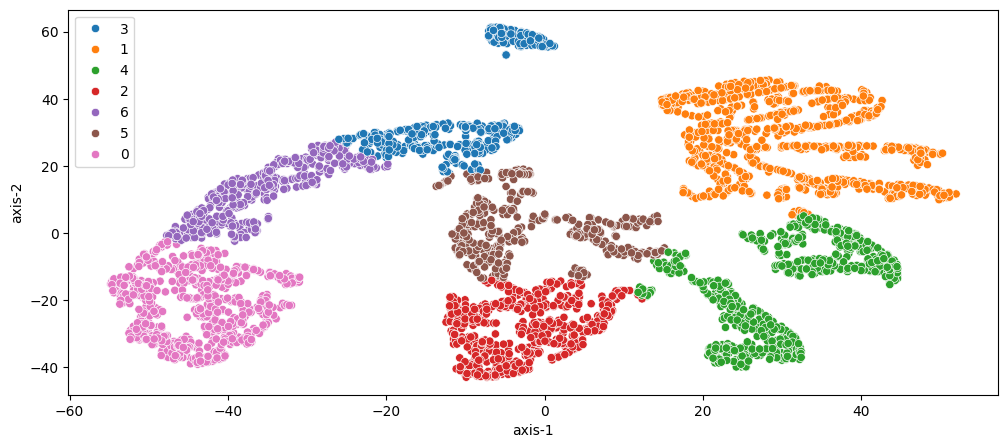

In [56]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_tsne, x='axis-1', y='axis-2', hue=k_means.labels_.astype('str'));


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. 


### Задание 6.6

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков. Для наглядности округлите все значения в столбцах до целого числа.

Чему равно максимальное среднее значение признака Recency в полученной таблице? Ответ округлите до целого числа.

In [57]:
rfm_filtered['labels_K_means'] = k_means.labels_
grouped = rfm_filtered.iloc[:, 1:].groupby('labels_K_means').mean()
print('Максимальное среднее значение признака Recency: ', grouped['Recency'].max().round())

Максимальное среднее значение признака Recency:  313.0


### Задание 6.7
Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

* Кластер 1 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер 4 соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер 2 соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер 5 соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер 0 соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер 6 соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер 3 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.



In [58]:
plot_cluster_profile(grouped, 7)

[Посмотреть интерактивный график](https://dafe1988.github.io/SF-DSPR-174/PROJECT-6/plotly/cluster_profile_7.html)

In [70]:
grouped

,Recency,Frequency,Monetary
labels_K_means,,,
0,46.329268,1.000000,321.538796
1,32.400438,6.770241,2416.582451
2,40.022099,1.979742,613.663941
3,313.000000,1.012594,261.105315
4,40.149341,3.450952,995.197350
5,195.800448,2.441704,670.317960
6,181.439506,1.000000,273.465160


## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов.Но как сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку?

Вы, вероятно, скажете: «Воспользоваться методом predict()!»

Верно, однако всё не так просто.

Вспомним, что мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Как же тогда производить кластеризацию для новых объектов, если мы не можем сжимать размерность для новых данных?

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

### Задание 7.1

Разделите исходные данные на тренировочную и тестовую выборки в соотношении 80/20. В качестве параметра random_state возьмите число 42.

Сколько клиентов попали в тестовую выборку?

In [60]:
# Создаём матрицу наблюдений X и вектор правильных ответов y
X = rfm_filtered.drop(['CustomerID', 'labels_K_means'], axis=1) #очищенная RFM-таблица
y = rfm_filtered['labels_K_means'] #метки кластеров, предсказанные ранее

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (3235, 3)
Test shape: (809, 3)


Дальше нам осталось только построить несколько моделей и выбрать из них лучшую. 
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут (можете убедиться в этом самостоятельно, обучив модель логистической регрессии на тренировочной выборке и оценив качество на тестовой).

Поэтому давайте сразу возьмём тяжелую артиллерию — ансамблевые алгоритмы. 


### Задание 7.2
Начнём со случайного леса. С помощью GridSearchCV организуйте перебор параметров случайного леса (RandomForestClassifier) на следующей сетке параметров:

```
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
```
В качестве параметра random_state для модели случайного леса используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5.

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в случайном лесу?

2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [63]:
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

# Настройка GridSearchCV
grid_rf = model_selection.GridSearchCV(ensemble.RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Обучение на обучающей выборке 
grid_rf.fit(X_train, y_train)

# Извлекаем лучшие параметры
best_params = grid_rf.best_params_
print("Лучшие параметры:", best_params)

# Строим модель с этими параметрами
best_rf = ensemble.RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

y_pred_best_rf = best_rf.predict(X_test)
accuracy_best_rf = metrics.accuracy_score(y_test, y_pred_best_rf)

print("accuracy for best RandomForestClassifier:", round(accuracy_best_rf, 3))

Лучшие параметры: {'criterion': 'gini', 'max_depth': 13, 'n_estimators': 200}
accuracy for best RandomForestClassifier: 0.985


Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

### Задание 7.3
С помощью GridSearchCV организуйте перебор параметров градиентного бустинга (GradientBoostingClassifier) на следующей сетке параметров:
```
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
```

В качестве параметра random_state для модели градиентного бустинга используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5. 

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в градиентном бустинге?
Ответ: 6
2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [64]:
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

# Настройка GridSearchCV
grid_gbc = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Обучение на обучающей выборке 
grid_gbc.fit(X_train, y_train)

# Извлекаем лучшие параметры
best_params = grid_gbc.best_params_
print("Лучшие параметры:", best_params)

# Строим модель с этими параметрами
best_gbc = ensemble.GradientBoostingClassifier(**best_params, random_state=42)
best_gbc.fit(X_train, y_train)

y_pred_best_gbc = best_gbc.predict(X_test)
accuracy_best_gbc = metrics.accuracy_score(y_test, y_pred_best_gbc)

print("accuracy for best GradientBoostingClassifier:", round(accuracy_best_gbc, 3))

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
accuracy for best GradientBoostingClassifier: 0.983


Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.